In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

board_games = pd.read_csv('board_games.csv')
print(board_games.head())

       id       type                                       name  \
0   12333  boardgame                          Twilight Struggle   
1  120677  boardgame                              Terra Mystica   
2  102794  boardgame                  Caverna: The Cave Farmers   
3   25613  boardgame  Through the Ages: A Story of Civilization   
4    3076  boardgame                                Puerto Rico   

   yearpublished  minplayers  maxplayers  playingtime  minplaytime  \
0         2005.0         2.0         2.0        180.0        180.0   
1         2012.0         2.0         5.0        150.0         60.0   
2         2013.0         1.0         7.0        210.0         30.0   
3         2006.0         2.0         4.0        240.0        240.0   
4         2002.0         2.0         5.0        150.0         90.0   

   maxplaytime  minage  users_rated  average_rating  bayes_average_rating  \
0        180.0    13.0        20113         8.33774               8.22186   
1        150.0    12.0

Reading in the dataset on Board Game Reviews. The important columns being:
    name -- name of the board game.
    playingtime -- the playing time (given by the manufacturer).
    minplaytime -- the minimum playing time (given by the manufacturer).
    maxplaytime -- the maximum playing time (given by the manufacturer).
    minage -- the minimum recommended age to play.
    users_rated -- the number of users who rated the game.
    average_rating -- the average rating given to the game by users. (0-10)
    total_weights -- Number of weights given by users. Weight is a subjective measure that is made up by       BoardGameGeek. It's how "deep" or involved a game is. Here's a full explanation.
    average_weight -- the average of all the subjective weights (0-5).

In [2]:
print(board_games.shape)
board_games.dropna(axis=0,inplace=True) #Removing any rows with missing values

board_games = board_games[board_games['users_rated']!=0] #Removing any rows where Users Rating = 0 i.e Ratings haven't been measured
print(board_games.shape)

(81312, 20)
(56894, 20)


Just some cleaning of the dataset. Removing any rows with missing values and any rows where the 'Users Rating' = 0 i.e there is no User Rating score.
We can see that the number of rows reduce considerably after cleaning the dataset.

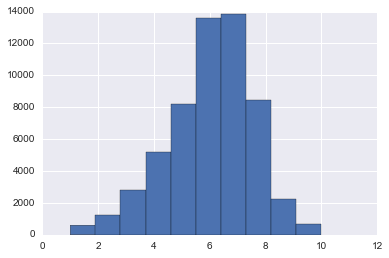

In [3]:
plt.hist(board_games['average_rating'])
plt.show()

Trying to understand how other columns might affect the average rating of a board game, but before that need to understand the column itself and need to decide on an "Error Metric".

In [4]:
print(board_games['average_rating'].std()) #Standard Deviation 

1.5788299348332662


In [5]:
print(board_games['average_rating'].mean()) #Average 

6.016112849333889


In order to choose an error metric, we need to understand the column first. The salient feature of which are:

1. The column follows somewhat of a Normal Distribution
2. The data or the values are continuous and not discreet

Hence, MSE (Mean Squared Error) seems a good error metric in this case.

In [6]:
print(board_games.columns)

Index(['id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated',
       'average_rating', 'bayes_average_rating', 'total_owners',
       'total_traders', 'total_wanters', 'total_wishers', 'total_comments',
       'total_weights', 'average_weight'],
      dtype='object')


In [7]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=5,random_state=1)  #Initializing a KMeans model with 5 clusters
numeric_columns = board_games[board_games.columns[3:len(board_games.columns)]]  #Extracting only the numeric columns
print(numeric_columns.head())

   yearpublished  minplayers  maxplayers  playingtime  minplaytime  \
0         2005.0         2.0         2.0        180.0        180.0   
1         2012.0         2.0         5.0        150.0         60.0   
2         2013.0         1.0         7.0        210.0         30.0   
3         2006.0         2.0         4.0        240.0        240.0   
4         2002.0         2.0         5.0        150.0         90.0   

   maxplaytime  minage  users_rated  average_rating  bayes_average_rating  \
0        180.0    13.0        20113         8.33774               8.22186   
1        150.0    12.0        14383         8.28798               8.14232   
2        210.0    12.0         9262         8.28994               8.06886   
3        240.0    12.0        13294         8.20407               8.05804   
4        150.0    12.0        39883         8.14261               8.04524   

   total_owners  total_traders  total_wanters  total_wishers  total_comments  \
0         26647            372      

In [8]:
kmeans_model.fit(numeric_columns)
labels = kmeans_model.labels_
print(labels)

[1 1 1 ..., 0 0 0]


Using a KMeans Clustering algo to fit a model with only the numeric columns and then extracting the labels. In order to visualize the model properly, we need to calculate the mean and standard deviation for each column and then plot it out.

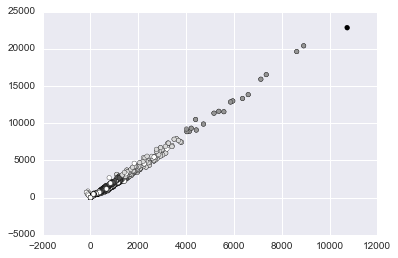

In [9]:
game_mean = numeric_columns.apply(np.mean,axis=1) #Calculating mean for every column
game_std = numeric_columns.apply(np.std,axis=1)  #Calculating standard dev for every column

plt.scatter(x=game_mean,y=game_std,c=labels)
plt.show()

From the clustering above, we can see that most of the games are very similarly ranked or weighted or equally played since the clusters are grouped very closely together.
Although there are a few outliers or clusters where once the game attributes tend to increase in value, there are only a few high quality games.

In [10]:
correlations = numeric_columns.corr()
print(correlations['average_rating'])

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64


Now that we have some idea about the data itself, we can now try and understand which columns are strongly correlated with 'average rating' and how to use it to define a LinearModel.

Some interesting observations are:

1. The year published column seems to have a strong correlation with average_rating which indicates that the more recently published games have a better average rating.
2. The games with a higher minimum age for playing tends to correlate to a higher average rating.
3. Also, the more involved a game is i.e the higher the average_weight, the better the game is rated which is a pretty straightforward deduction.

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
cols = list(numeric_columns.columns)
cols.remove('average_rating')
cols.remove('bayes_average_rating')
lr.fit(board_games[cols], board_games['average_rating'])
predictions = lr.predict(board_games[cols])

error_metric = np.mean((predictions - board_games['average_rating']) ** 2)
print(error_metric)

2.0933969758339432


Our Linear Regression model here has a MSE value of 2.09 which is quite bad since it is close to the Standard Deviation.
Hence, the model is not quite effective at prediction. We need to inspect the game reviews more to understand which games were reviewed higher and which were not.

In [12]:
np.random.seed(8)
shuffled_index = np.random.permutation(board_games.index)
shuffled_board_games = board_games.loc[shuffled_index]
train = shuffled_board_games.iloc[0:42671]
test = shuffled_board_games.iloc[42671:len(shuffled_board_games)]
print(shuffled_board_games.head())

           id       type                                               name  \
12640  126207  boardgame                             Deer in the Headlights   
70637  153686  boardgame  Clash Fighter: The Real Time Fighting Card Gam...   
28901   23989  boardgame                                       Driving Test   
60782  122647  boardgame                                           The Cube   
22408   15964  boardgame                                       Final Yamato   

       yearpublished  minplayers  maxplayers  playingtime  minplaytime  \
12640         2012.0         2.0       104.0         30.0         30.0   
70637         2014.0         2.0        12.0          5.0          5.0   
28901         1955.0         1.0         0.0          0.0          0.0   
60782         2011.0         2.0         6.0          1.0          1.0   
22408         1985.0         1.0         2.0        360.0        360.0   

       maxplaytime  minage  users_rated  average_rating  bayes_average_rating  \

In the above model that we cerated, we tested our data on our training set itself which is not the appropriate practice.
Hence, now we have divided our data into training and test data. We will then train our LinearModel on the train data and try to predict values on test data and calculate the efficiency of our model.

In [13]:
lr = LinearRegression()
lr.fit(train[cols],train['average_rating'])
predictions = lr.predict(test[cols])

error_metric = np.mean((predictions - test['average_rating']) ** 2)
print(error_metric)

2.0946995266410666


Even though we have bifurcated our test and train data, our MSE value is still 2.094 which again fails to be efficient at predicting.

In [14]:
player_range = board_games['maxplayers'] - board_games['minplayers']
board_games['player_range'] = player_range
playtime_range = board_games['maxplaytime'] - board_games['minplaytime']
board_games['playtime_range'] = playtime_range
avg_no_rating = board_games['total_owners'] / board_games['users_rated']
board_games['avg_no_rating'] = avg_no_rating

In [16]:
numeric_columns = board_games[board_games.columns[3:len(board_games.columns)]]  #Extracting only the numeric columns
correlations = numeric_columns.corr()
print(correlations['average_rating'])

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
player_range           -0.007829
playtime_range          0.025640
avg_no_rating           0.172663
Name: average_rating, dtype: float64


Here, we created 3 new predictors:

1. Player Range = MaxPlayers - MinPlayers
2. Playtime Range = MaxPlayTime - MinPlayTime
3. Average Number of Ratings = Total Owners / Users_Rated

And then we find the correlation of these columns with 'average_rating' and find that the average_number of ratings has a strong correlation with average_rating.

In [17]:
np.random.seed(8)
shuffled_index = np.random.permutation(board_games.index)
shuffled_board_games = board_games.loc[shuffled_index]
train = shuffled_board_games.iloc[0:42671]
test = shuffled_board_games.iloc[42671:len(shuffled_board_games)]

cols = list(numeric_columns.columns)
cols.remove('average_rating')
cols.remove('bayes_average_rating')

lr = LinearRegression()
lr.fit(train[cols],train['average_rating'])
predictions = lr.predict(test[cols])

error_metric = np.mean((predictions - test['average_rating']) ** 2)
print(error_metric)

2.0327912441628


The MSE value reduced from 2.09 to 2.03 when we added a new predictor but still is not a good model for prediction.